<a href="https://colab.research.google.com/github/raverinpuff/arina-ML/blob/main/%D1%81%D0%B2%D1%91%D1%80%D1%82%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/stopwords-iso/stopwords-en/blob/ccc8898188850d8fb019d5f69c14a6635c3bd115/stopwords-en.txt

--2025-05-24 15:56:32--  https://github.com/stopwords-iso/stopwords-en/blob/ccc8898188850d8fb019d5f69c14a6635c3bd115/stopwords-en.txt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘stopwords-en.txt’

stopwords-en.txt        [  <=>               ] 186.94K   774KB/s    in 0.2s    

2025-05-24 15:56:33 (774 KB/s) - ‘stopwords-en.txt’ saved [191427]



In [2]:
with open('stopwords-en.txt', 'r') as f:
  stopwords = f.read().split()

# импортируем список стоп-слов и вписываем файл в переменную

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import requests
import tensorflow_text as tf_text
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = pd.read_csv("hf://datasets/Senem/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data.csv")

# импортируем библиотеки и рабочий датасет

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
df = df.dropna()

# убираем пустоты

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  1500 non-null   object
 1   comment    1500 non-null   object
dtypes: object(2)
memory usage: 23.6+ KB


In [6]:
def cleaning(text):
  text = text.lower()
  text = re.sub(r'[^a-z\s]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  text = [word for word in text.split() if word not in stopwords]

  return ' '.join(text)

# прописываем функцию для чистки текста от лишних знаков и стоп-слов


df['comment'] = df['comment'].apply(cleaning)
df['comment'].head(10)

# применяем чистку к столбцу с комментариями

,comment
0,he singer golden voice i love hear the time i ...
1,the mist beautiful voice ever i listened him w...
2,i have most mr reeves songs always love his sm...
3,day leave from st tour viet nam convince mary ...
4,listening his songs reminds me mum who played ...
5,time i heard song as child i used crybecause i...
6,dad loved listening jim reeves when i teenager...
7,i have also listened jim reeves since childhoo...
8,wherever you are you always heart
9,elvis will always number one no one come close...


In [7]:
# делим данные на текст и метки
texts = df['comment'].values
labels = LabelEncoder().fit_transform(df['sentiment'])

# создаём слой TextVectorization
from tensorflow.keras.layers import TextVectorization
max_tokens = 1000  # Максимальное количество слов в словаре
sequence_length = 25  # Максимальная длина последовательности
vectorizer = TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=sequence_length)

# адаптируем слой к данным
vectorizer.adapt(texts)

# векторизируем тексты
vectorized_texts = vectorizer(texts).numpy()

print(f"Пример векторизованного текста:\n\n {vectorized_texts[33]} \n\nПример другого текста: \n\n {vectorized_texts[3]}")

# слова Ани Сугян: слой TextVectorization автоматически выполняет паддинг и усечение до указанной длины (output_sequence_length). Если длина текста меньше, он дополняется нулями; если больше — обрезается.


Пример векторизованного текста:

 [ 52  15  61   3 372 676   1 320 190 624   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0] 

Пример другого текста: 

 [ 92 456  30 543 872   1   1   1 360 966 643   6  10   2 115  11  30 949
 872  33  18 207   1 139   1]


In [8]:
# делим данные на обучающую, проверочную и тестовую выборки

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(vectorized_texts, labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [9]:
# строим модельку

from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Embedding(input_dim=20000, output_dim=16),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [15]:
# перед обучением делаем компиляцию
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# обучаем модельку
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=30)

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5331 - loss: 0.6918 - val_accuracy: 0.5500 - val_loss: 0.6887
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6784 - loss: 0.6766 - val_accuracy: 0.7833 - val_loss: 0.5906
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8425 - loss: 0.4804 - val_accuracy: 0.9083 - val_loss: 0.2450
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9281 - loss: 0.1847 - val_accuracy: 0.9417 - val_loss: 0.1847
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9599 - loss: 0.1101 - val_accuracy: 0.9333 - val_loss: 0.1808


In [17]:
# посмотрим, какова точность модели на тестовой выборке
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8712 - loss: 0.3243
Точность на тестовой выборке: 0.8567


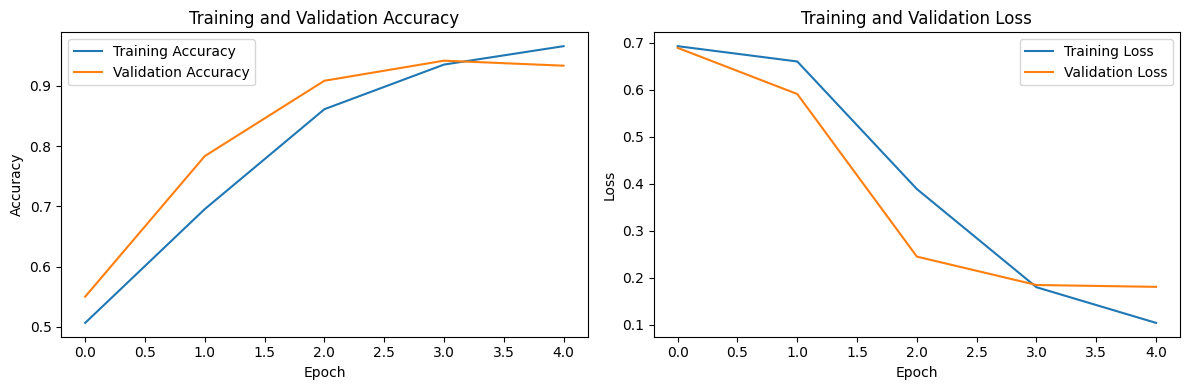

In [19]:
# отрисуем график прогресса обучения
plt.figure(figsize=(12, 4))

# отрисуем график аккуратности (точности) модели
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# отрисуем значения функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# честно говоря, выглядит вроде неплохо!!

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


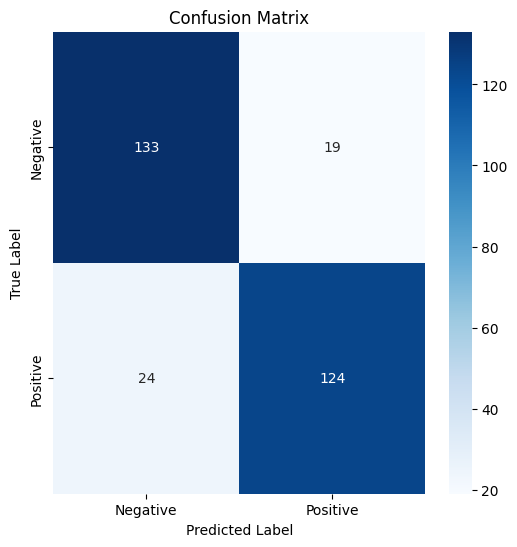

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# получаем предсказания на тестовых данных
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)  # Преобразуем вероятности в метки (0 или 1)

# создаём матрицу ошибок
cm = confusion_matrix(y_test, y_pred)

# визуализируем
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [23]:
# посмотрим, что изменится при другой настройке параметров. построим ещё одну модельку

model_2 = models.Sequential([
    layers.Embedding(input_dim=20000, output_dim=16),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# перед обучением делаем компиляцию
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# обучаем модельку
history = model_2.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10, # попробуем увеличить до 10
    batch_size=40) # попробуем увеличить до 40

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.4940 - loss: 0.6936 - val_accuracy: 0.4917 - val_loss: 0.6886
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5499 - loss: 0.6803 - val_accuracy: 0.8250 - val_loss: 0.6287
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8256 - loss: 0.5599 - val_accuracy: 0.9333 - val_loss: 0.2665
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9248 - loss: 0.2371 - val_accuracy: 0.9333 - val_loss: 0.1800
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9584 - loss: 0.1239 - val_accuracy: 0.9417 - val_loss: 0.1916
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9799 - loss: 0.0848 - val_accuracy: 0.9333 - val_loss: 0.1866
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9877 - loss: 0.0591 - val_accuracy: 0.9333 - val_loss: 0.2130
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9891 - loss: 0.0400 - val_accuracy: 0.9333 - val_loss

In [24]:
# посмотрим, как дела с точностью у второй модели
test_loss, test_accuracy = model_2.evaluate(x_test, y_test)
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

# точность понизилась :(

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8697 - loss: 0.4925
Точность на тестовой выборке: 0.8500


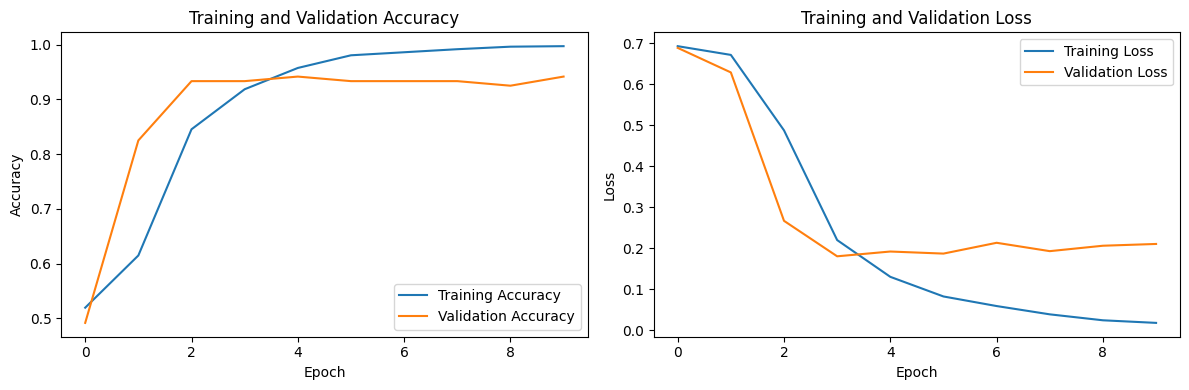

In [25]:
# отрисуем график прогресса обучения второй модели
plt.figure(figsize=(12, 4))

# отрисуем график аккуратности (точности) второй модели
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# отрисуем значения функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# уфффффф..........

In [26]:
# сохраняем первый вариант модели

model.save('my_CNN_model.keras')